# **Scrap-Website-Example**

In this first work I will try to scrap the list of seasonal fruits and vegetables from the website: https://www.lesfruitsetlegumesfrais.com/

In [1]:
import requests
from bs4 import BeautifulSoup

response = requests.get('https://www.lesfruitsetlegumesfrais.com/calendrier-fruits-legumes/fevrier')
html_content = response.content

soup = BeautifulSoup(html_content, 'html.parser')

# Find all span elements with the class 'name'
names = soup.find_all('span', class_='name')

# Extract the text from each span element
#for name in names:
#    print(name.text)

In [2]:
import pandas as pd

columns = ["Janvier", "Fevrier", "Mars", "Avril", "Mai", "Juin", "Juillet", "Aout", "Septembre", "Octobre", "Novembre", "Decembre"]
seasonal_data = pd.DataFrame()
max_length = 0
data_dict = {}
print(seasonal_data)

Empty DataFrame
Columns: []
Index: []


In [3]:
for month in columns:
    url = 'https://www.lesfruitsetlegumesfrais.com/calendrier-fruits-legumes/'
    url = url + month.lower()
    
    response = requests.get(url)
    html_content = response.content
    soup = BeautifulSoup(html_content, 'html.parser')

    names = soup.find_all('span', class_='name')
    month_data = [name.text for name in names]
    
    # Update max_length if current list is longer
    if len(month_data) > max_length:
        max_length = len(month_data)
    
    data_dict[month] = month_data

# Now create the DataFrame with columns of equal length
for month, month_data in data_dict.items():
    # Pad month_data if it's not the longest one
    if len(month_data) < max_length:
        month_data += [None] * (max_length - len(month_data))
    seasonal_data[month] = month_data
    
#seasonal_data

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

all_items = pd.unique(seasonal_data.values.ravel('K'))
all_items = [item for item in all_items if item is not None]
all_items.sort()

sorted_seasonal_data = pd.DataFrame(index=all_items, columns=seasonal_data.columns)

for month in seasonal_data.columns:
    for item in all_items:
        sorted_seasonal_data.at[item, month] = item in seasonal_data[month].values
        
#sorted_seasonal_data

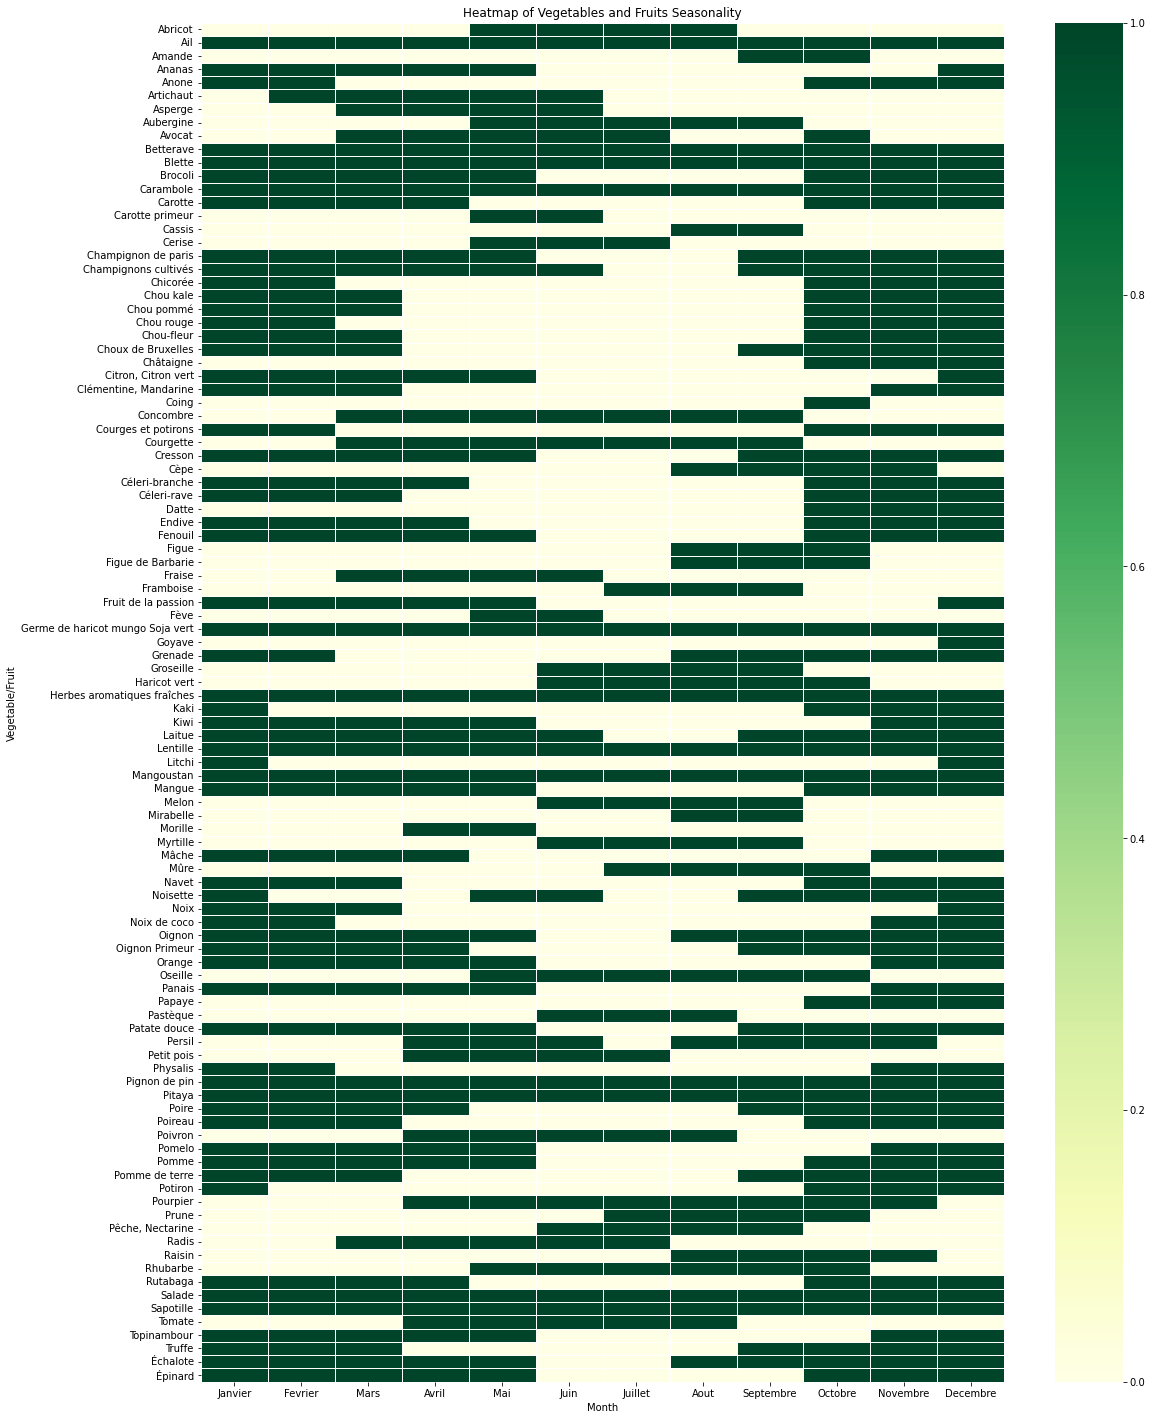

In [5]:
heatmap_data = sorted_seasonal_data.replace({True: 1, False: 0})

plt.figure(figsize=(18, 25))
sns.heatmap(heatmap_data, cmap='YlGn', linewidths=.5, annot=False)
plt.title('Heatmap of Vegetables and Fruits Seasonality')
plt.xlabel('Month')
plt.ylabel('Vegetable/Fruit')
plt.show()


Trying to scrap: https://www.opentable.fr/

In [6]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException, TimeoutException, StaleElementReferenceException
import time

# Function to extract text from the menu section
def extract_menu_text(driver):
    try:
        WebDriverWait(driver, 10).until(
            EC.visibility_of_element_located((By.ID, "menu"))
        )
        
        # If no article elements are found, return an empty list immediately
        articles = driver.find_elements(By.CSS_SELECTOR, "#menu article")
        if not articles:
            #print("No articles found inside the menu.")
            return []
        
        try:
            complete_menu_button = driver.find_element(By.XPATH, "//button[contains(text(), 'Voir le menu complet')]")
            
            # Click the button (Required to get all the articles and not just the visible ones)
            complete_menu_button.click()
        except NoSuchElementException:
            pass
        
        # Wait for at least one article element to appear within the menu
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "#menu article"))
        )
        
        # Find all article elements within the menu
        articles = driver.find_elements(By.CSS_SELECTOR, "#menu article")

        # For each article, find all h4 and p and extract the text
        all_texts = []
        for article in articles:
            h4_texts = [h4.text for h4 in article.find_elements(By.TAG_NAME, 'h4')]
            p_texts = [p.text for p in article.find_elements(By.TAG_NAME, 'p')]
            
            # Combine the lists and add them to the all_texts list
            all_texts.extend(h4_texts + p_texts)
        
        #return menu_texts
        return all_texts
    
    except TimeoutException:
        print("Timeout waiting for the menu to load.")
        return []

In [7]:
import re

# Function to clean up the menu item strings
def clean_menu_list(menu_list):
    combined_menu = ' '.join(menu_list)
    combined_menu = combined_menu.lower()

    # Remove numbers and special characters (keeping only words and spaces)
    cleaned_menu = re.sub(r'[^a-z\s]', '', combined_menu)

    menu_words = cleaned_menu.split()
    unique_menu_words = list(set(menu_words))

    return unique_menu_words

In [8]:
def scroll_down_by_incrementation(driver, last_height):
    # Scroll down to the bottom
    for i in range(0, last_height, 300):
        driver.execute_script(f"window.scrollTo(0, {i});")
        time.sleep(0.25)

In [11]:
def get_reviews(driver):
    reviews_for_csv = []

    # Wait for the reviews list to be present
    while True:
        try:
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.ID, "restProfileReviewsContent"))
            )
            
            # Locate the list that contains the reviews
            reviews_list = driver.find_elements(By.CSS_SELECTOR, "ol#restProfileReviewsContent > li[data-test='reviews-list-item']")

            for review_unit in reviews_list: 
                rating = review_unit.find_element(By.CSS_SELECTOR, ".b4kg-oLxYz8-")
                rating_values = rating.get_attribute('textContent').strip()
                
                # Extract the numerical ratings, assuming they are contained in 'span' elements with a specific class
                detail_ratings = review_unit.find_elements(By.CSS_SELECTOR, "span.-y00OllFiMo-")
                detail_ratings_values = [rating.get_attribute('textContent').strip() for rating in detail_ratings]

                # Extract the review text, assuming it is contained in a 'span' with a specific class or data attribute
                review_text_element = review_unit.find_element(By.CSS_SELECTOR, "span[data-test='wrapper-tag']")
                review_text = review_text_element.get_attribute('textContent').strip()
                
                # Add review_data to list
                reviews_for_csv.append([rating_values] + detail_ratings_values + [review_text])
                print('review:', [rating_values] + detail_ratings_values + [review_text])
                
            # Travel to next pages to get every review
            try:
                driver.refresh()
                next_reviews_button = WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.CSS_SELECTOR, ".TkpxbcBbu80- > a[aria-label='Aller à la page suivante']"))) # Careful, the driver needs to be in French and not in English
                next_reviews_button.click()
                time.sleep(0.1)
            except NoSuchElementException:
                break
    
        except TimeoutException:
            print("Timed out waiting for reviews to load.")
            return []

    return reviews_for_csv

In [12]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.get("https://www.opentable.fr/")
time.sleep(0.5)

# Find the search input field by the 'data-test' attribute and enter 'Paris'
input_field = driver.find_element(By.CSS_SELECTOR, "input[data-test='search-autocomplete-input']")
input_field.send_keys("Paris")

# Find the search button by its 'aria-label' and click it
search_button = driver.find_element(By.CSS_SELECTOR, "button[aria-label='Rechercher']")
search_button.click()
time.sleep(1)

# Initialize a list to hold all the data for the CSV
data_for_csv = []
reviews_for_csv = []
    
while True:

    last_height = driver.execute_script("return document.body.scrollHeight")
    scroll_down_by_incrementation(driver, last_height)
    time.sleep(1)
    
    # Collect the card elments
    try:
        cards = WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, ".multiSearchRestaurantCard"))
        )
    except TimeoutException:
        print("Timeout waiting for the restaurant cards to load.")

    # Safely iterate over each card to extract the link
    for card in cards:
        main_window = driver.current_window_handle

        link_element = card.find_element(By.TAG_NAME, 'a')
        link = link_element.get_attribute('href')
        driver.execute_script("window.open(arguments[0]);", link)  # Open link in new tab
        time.sleep(0.5)

        # Switch to new tab
        driver.switch_to.window(driver.window_handles[1])
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'body')))  # Wait for the page body to be present
        
        # Extract the restaurant name
        name_element = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, 'h1.E-vwXONV9nc-'))
        )
        restaurant_name = name_element.text
        
        # Get the number of stars
        try:
            stars_element = driver.find_element(By.CSS_SELECTOR, "#ratingInfo > span")
            stars = stars_element.text
        except NoSuchElementException:
            stars = ""

        # Get the price range
        try:
            price_range_element = driver.find_element(By.CSS_SELECTOR, "#priceBandInfo > span:nth-of-type(2)")
            price_range = price_range_element.text
        except NoSuchElementException:
            price_range = ""

        # Get the type of cuisine
        try:
            cuisine_element = driver.find_element(By.CSS_SELECTOR, "#cuisineInfo > span:nth-of-type(2)")
            cuisine = cuisine_element.text
        except NoSuchElementException:
            cuisine = ""
        
        # Extract text from the menu
        menu_words = extract_menu_text(driver)
        
        # Clean the menu items
        cleaned_menu_items = clean_menu_list(menu_words)
        
        # Add the restaurant name and cleaned menu items to the data list
        data_for_csv.append([restaurant_name] + [stars] + [price_range] + [cuisine] + [cleaned_menu_items])
        
        # Add the reviews to the review list
        restaurant = get_reviews(driver)
        for review_data in restaurant:
            reviews_for_csv.append([restaurant_name] + review_data)
            print("csv:", [restaurant_name] + review_data)
    
        # Close the current tab
        driver.close()

        # Switch back to the main window
        driver.switch_to.window(main_window)
        time.sleep(0.5)
        
    # Travel to next pages to get every restaurant
    try:
        next_page_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "div.TkpxbcBbu80- > a[aria-label='Aller à la page suivante']"))) # Careful, the driver needs to be in French and not in English
        next_page_button.click()
        time.sleep(0.5)
    except NoSuchElementException:
        break
        
# Close the browser
driver.quit()

review: ['5.0', '5', '5', '5', '5', 'The dinner was a private, romantic birthday dinner for my wife and the staff and the food did not disappoint. Cozy table by the window overlooking the Eiffel Tower was awesome! Waiter was excellent and also volunteered to be our photographer. Food was delicious. My wife love it!']
review: ['5.0', '5', '5', '5', '5', 'Great place for food and drinks . Staff are super friendly. Amazing time !!! Thank you']
review: ['2.0', '2', '2', '2', '2', 'Llegamos y la cocina estaba cerrada y nos sacaron a las 2 horas\nPrecio calidad no se justifica']
review: ['3.0', '3', '3', '2', '4', 'The food and service were both okay. The view of the Eiffel Tower was amazing. All went well throughout our experience until the end when our server brought our check to us. Upon handing over the bill, he knelt down to interrupt our conversation and told my husband and I “this is the bill and it is customary to add a ten to twenty percent tip onto this total.” It became very awkwa

In [ ]:
import csv

# Write the data to a CSV file
with open('restaurants.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Restaurant_Name', 'Ranking', 'Price_Range', 'Cuisine_Type', 'Menu Items'])
    writer.writerows(data_for_csv)

print("CSV file has been created.")

CSV file has been created.


In [ ]:
with open('reviews.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["Restaurant_Name", "Ranking", "Global_Ranking", "Plats_Ranking", "Service_Ranking", "Atmosphere_Ranking", "Text"])
    writer.writerows(reviews_for_csv)

print("CSV file has been created.")

### To do:
- Get other pages of restaurants
- Translate list of ingredients in french
- Make a json with name of restaurant and list of ingredients

### To do for other group member's:
- Scrap for each restaurant: average price, number of star, location, type of restaurant (french, italian,...)
- Get a json with name of the restaurant and all these data in french

#### Then with these two json we will be able to make some analyses and graphs.